# Philadelphia Economic Mobility Analysis

This notebook analyzes economic mobility in Philadelphia compared to national trends, using data from the Opportunity Atlas project by Chetty et al.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

# Set plot style using Seaborn
sns.set_theme(style="whitegrid")  # You can choose other styles like "darkgrid", "white", "dark", "ticks"
sns.set_palette("deep")


## Data Loading and Preprocessing

In [3]:
# Load data
county_cohort_data = pd.read_csv('../data/raw/county_by_cohort_estimates.csv')
county_trends_data = pd.read_csv('../data/raw/Table_1_county_trends_estimates.csv')
cz_trends_data = pd.read_csv('../data/raw/Table_2_cz_trends_estimates.csv')
cz_cohort_data = pd.read_csv('../data/raw/Table_4_cz_by_cohort_estimates.csv')
national_primary_data = pd.read_csv('../data/raw/Table_5_national_estimates_by_cohort_primary_outcomes.csv')
national_secondary_data = pd.read_csv('../data/raw/Table_6_national_estimates_by_cohort_secondary_outcomes.csv')
percentile_dollar_crosswalk = pd.read_csv('../data/raw/Table_7_percentile_dollar_crosswalk.csv')
county_covariates = pd.read_csv('../data/raw/Table_8_county_covariates.csv')
cz_covariates = pd.read_csv('../data/raw/Table_9_cz_covariates.csv')

# Identify Philadelphia's county and CZ codes
philly_county_code = '42101'  # Philadelphia County FIPS code
philly_cz_code = '37980'  # Philadelphia CZ code (verify this)

# Filter data for Philadelphia
philly_county_cohort = county_cohort_data[county_cohort_data['county'] == philly_county_code]
philly_county_trends = county_trends_data[county_trends_data['county'] == philly_county_code]
philly_cz_cohort = cz_cohort_data[cz_cohort_data['cz'] == philly_cz_code]
philly_cz_trends = cz_trends_data[cz_trends_data['cz'] == philly_cz_code]


## Economic Mobility Trends

In [12]:
def plot_mobility_trend(data, outcome, title, percentile='p25', gender='pooled'):
    plt.figure(figsize=(12, 6))
    for race in ['white', 'black', 'hisp', 'asian', 'aian']:
        column_name = f'{outcome}_{race}_{gender}_{percentile}'
        if column_name in data.columns:
            plt.plot(data['cohort'], data[column_name], label=f'{race.capitalize()}')
        else:
            print(f"Column {column_name} not found in the data")
    plt.title(title)
    plt.xlabel('Birth Cohort')
    plt.ylabel(f'{outcome.upper()} Outcome')
    plt.legend()
    plt.show()

print("Philadelphia County Cohort Data Shape:", philly_county_cohort.shape)
print("\nPhiladelphia County Cohort Columns:")
print(philly_county_cohort.columns)
print("\nFirst few rows of Philadelphia County Cohort Data:")
print(philly_county_cohort.head())
kfr_columns = [col for col in philly_county_cohort.columns if 'kfr' in col]
print("\nColumns containing 'kfr':")
print(kfr_columns)
print("\nUnique column prefixes:")
print(set([col.split('_')[0] for col in philly_county_cohort.columns]))


Philadelphia County Cohort Data Shape: (0, 725)

Philadelphia County Cohort Columns:
Index(['state', 'county', 'cohort', 'state_name', 'county_name',
       'kfr_aian_female_p1', 'kfr_asian_female_p1', 'kfr_black_female_p1',
       'kfr_hisp_female_p1', 'kfr_pooled_female_p1',
       ...
       'kfi_asian_pooled_p100', 'kii_asian_pooled_p100',
       'kfi_black_pooled_p100', 'kii_black_pooled_p100',
       'kfi_hisp_pooled_p100', 'kii_hisp_pooled_p100',
       'kfi_pooled_pooled_p100', 'kii_pooled_pooled_p100',
       'kfi_white_pooled_p100', 'kii_white_pooled_p100'],
      dtype='object', length=725)

First few rows of Philadelphia County Cohort Data:
Empty DataFrame
Columns: [state, county, cohort, state_name, county_name, kfr_aian_female_p1, kfr_asian_female_p1, kfr_black_female_p1, kfr_hisp_female_p1, kfr_pooled_female_p1, kfr_white_female_p1, kfr_aian_male_p1, kfr_asian_male_p1, kfr_black_male_p1, kfr_hisp_male_p1, kfr_pooled_male_p1, kfr_white_male_p1, kfr_aian_pooled_p1, kfr_asi

In [13]:
print("Unique county codes:")
print(county_cohort_data['county'].unique())
philly_count = county_cohort_data[county_cohort_data['county'] == philly_county_code].shape[0]
print(f"Number of rows for Philadelphia (county code {philly_county_code}): {philly_count}")
print("Counties containing 'Philadelphia':")
print(county_cohort_data[county_cohort_data['county_name'].str.contains('Philadelphia', case=False, na=False)])
# Assuming we found the correct way to filter Philadelphia data
philly_county_cohort = county_cohort_data[county_cohort_data['county_name'].str.contains('Philadelphia', case=False, na=False)]

print("Philadelphia data shape:", philly_county_cohort.shape)
print("\nFirst few rows of Philadelphia data:")
print(philly_county_cohort.head())

Unique county codes:
[  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127 129 131 133  20  50  60  68  70
  90 110 122 130 150 164 170 180 185 188 195 198 220 240 261 270 275 290
  12 135 137 139 141 143 145 147 149  14  86 151 153 155 157 159 161 163
 165 167 169 171 173 175 177 179 181 183 187 189 191 193 197 199 201 205
 207 209 211 213 215 217 219 221 223 225 227 229 231 233 235 237 239 241
 243 245 247 249 251 253 255 257 259 263 265 267 269 271 273 277 279 281
 283 285 287 289 291 293 295 297 299 301 303 305 307 309 311 313 315 317
 319 321 203 510 186   6  28 323 325 327 329 331 333 335 337 339 341 343
 345 347 349 351 353 355 357 359 361 363 365 367 369 371 373 375 377 379
 381 383 385 387 389 391 393 395 397 399 401 403 405 407 409 411 413 415
 417 419 421 423 425 427 429 4

Philadelphia data shape: (0, 725)

First few rows of Philadelphia data:
Empty DataFrame
Columns: [state, county, cohort, state_name, county_name, kfr_aian_female_p1, kfr_asian_female_p1, kfr_black_female_p1, kfr_hisp_female_p1, kfr_pooled_female_p1, kfr_white_female_p1, kfr_aian_male_p1, kfr_asian_male_p1, kfr_black_male_p1, kfr_hisp_male_p1, kfr_pooled_male_p1, kfr_white_male_p1, kfr_aian_pooled_p1, kfr_asian_pooled_p1, kfr_black_pooled_p1, kfr_hisp_pooled_p1, kfr_pooled_pooled_p1, kfr_white_pooled_p1, kfr_aian_female_p25, kfr_aian_female_p25_se, kfr_asian_female_p25, kfr_asian_female_p25_se, kfr_black_female_p25, kfr_black_female_p25_se, kfr_hisp_female_p25, kfr_hisp_female_p25_se, kfr_pooled_female_p25, kfr_pooled_female_p25_se, kfr_white_female_p25, kfr_white_female_p25_se, kfr_aian_male_p25, kfr_aian_male_p25_se, kfr_asian_male_p25, kfr_asian_male_p25_se, kfr_black_male_p25, kfr_black_male_p25_se, kfr_hisp_male_p25, kfr_hisp_male_p25_se, kfr_pooled_male_p25, kfr_pooled_male_p25_se

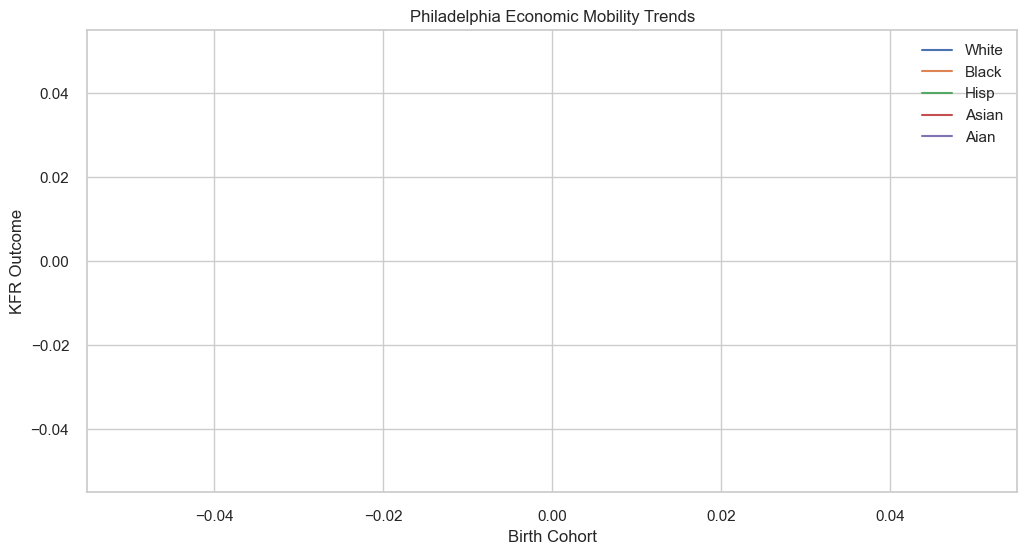

Column kfr_pooled_p25 not found in one or both datasets
Column kfr_pooled_p75 not found in one or both datasets


In [14]:
# Update the Philadelphia county code
philly_county_code = '101'

# Filter Philadelphia data correctly
philly_county_cohort = county_cohort_data[county_cohort_data['county'] == philly_county_code]

print("Philadelphia data shape:", philly_county_cohort.shape)
print("\nFirst few rows of Philadelphia data:")
print(philly_county_cohort.head())

# Now let's update our plotting function to work with this data
def plot_mobility_trend(data, outcome, title, percentile='p25', gender='pooled'):
    plt.figure(figsize=(12, 6))
    for race in ['white', 'black', 'hisp', 'asian', 'aian']:
        column_name = f'{outcome}_{race}_{gender}_{percentile}'
        if column_name in data.columns:
            plt.plot(data['cohort'], data[column_name], label=f'{race.capitalize()}')
        else:
            print(f"Column {column_name} not found in the data")
    plt.title(title)
    plt.xlabel('Birth Cohort')
    plt.ylabel(f'{outcome.upper()} Outcome')
    plt.legend()
    plt.show()

# Plot Philadelphia trends
plot_mobility_trend(philly_county_cohort, 'kfr', 'Philadelphia Economic Mobility Trends', 'p25', 'pooled')

# Update the comparison function
def compare_philly_to_national(outcome, percentile, gender='pooled'):
    column_name = f'{outcome}_{gender}_{percentile}'
    if column_name in national_primary_data.columns and column_name in philly_county_cohort.columns:
        national_avg = national_primary_data[column_name].mean()
        philly_avg = philly_county_cohort[column_name].mean()
        
        print(f"National average {outcome} ({percentile}, {gender}): {national_avg:.2f}")
        print(f"Philadelphia average {outcome} ({percentile}, {gender}): {philly_avg:.2f}")
        print(f"Difference: {philly_avg - national_avg:.2f}")
    else:
        print(f"Column {column_name} not found in one or both datasets")

# Compare Philadelphia to national trends
compare_philly_to_national('kfr', 'p25', 'pooled')
compare_philly_to_national('kfr', 'p75', 'pooled')


In [15]:
print("Unique county names:")
print(county_cohort_data['county_name'].unique())
philly_data = county_cohort_data[county_cohort_data['county_name'].str.contains('Philadelphia', case=False, na=False)]
print("Philadelphia data shape:", philly_data.shape)
print("\nFirst few rows of Philadelphia data:")
print(philly_data.head())
print("county_cohort_data shape:", county_cohort_data.shape)
print("\nFirst few rows of county_cohort_data:")
print(county_cohort_data.head())
print("\nColumn names:")
print(county_cohort_data.columns)
non_null_rows = county_cohort_data[county_cohort_data['kfr_pooled_pooled_p25'].notnull()]
print("Rows with non-null kfr_pooled_pooled_p25:", non_null_rows.shape)
print("\nFirst few rows with non-null data:")
print(non_null_rows.head())


Unique county names:
['Autauga' 'Baldwin' 'Barbour' ... 'Villalba' 'Yabucoa' 'Yauco']
Philadelphia data shape: (15, 725)

First few rows of Philadelphia data:
       state  county  cohort    state_name   county_name  kfr_aian_female_p1  \
34125     42     101    1978  Pennsylvania  Philadelphia                 NaN   
34126     42     101    1979  Pennsylvania  Philadelphia                 NaN   
34127     42     101    1980  Pennsylvania  Philadelphia                 NaN   
34128     42     101    1981  Pennsylvania  Philadelphia                 NaN   
34129     42     101    1982  Pennsylvania  Philadelphia                 NaN   

       kfr_asian_female_p1  kfr_black_female_p1  kfr_hisp_female_p1  \
34125             0.457616             0.305852            0.292228   
34126             0.509168             0.320318            0.323866   
34127             0.560030             0.313585            0.308644   
34128             0.492911             0.323969            0.291005   
34129